In [14]:
import os
os.getcwd()
os.chdir('/Users/admin/Downloads/V08901_Code/Section 3')

In [69]:
import pandas as pd

# some lines have too many fields (?), so skip bad lines
imgatt = pd.read_csv('image_attribute_labels.txt',
                     sep='\s+', header=None, error_bad_lines=False, warn_bad_lines=False,
                     usecols=[0,1,2], names=['imgid', 'attid', 'present'])

# description from dataset README:
# 
# The set of attribute labels as perceived by MTurkers for each image
# is contained in the file attributes/image_attribute_labels.txt, with
# each line corresponding to one image/attribute/worker triplet:
#
# <image_id> <attribute_id> <is_present> <certainty_id> <time>
#
# where <image_id>, <attribute_id>, <certainty_id> correspond to the IDs
# in images.txt, attributes/attributes.txt, and attributes/certainties.txt
# respectively.  <is_present> is 0 or 1 (1 denotes that the attribute is
# present).  <time> denotes the time spent by the MTurker in seconds.


In [70]:
imgatt.head()

imgid  attid  present
0      1      1        0
1      1      2        0
2      1      3        0
3      1      4        0
4      1      5        1

In [71]:
imgatt.shape

(3677856, 3)

In [72]:
# need to reorganize imgatt to have one row per imgid, and 312 columns (one column per attribute),
# with 1/0 in each cell representing if that imgid has that attribute or not

imgatt2 = imgatt.pivot(index='imgid', columns='attid', values='present')

In [73]:
imgatt2.head()

attid  1    2    3    4    5    6    7    8    9    10  ...   303  304  305  \
imgid                                                   ...                   
1        0    0    0    0    1    0    0    0    0    0 ...     0    0    0   
2        0    0    0    0    0    0    0    0    0    0 ...     0    0    0   
3        0    0    0    0    1    0    0    0    0    0 ...     0    0    0   
4        0    0    0    0    1    0    0    0    0    0 ...     0    0    0   
5        0    0    0    0    1    0    0    0    0    0 ...     0    0    1   

attid  306  307  308  309  310  311  312  
imgid                                     
1        0    0    1    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    1    0    0    1    0  
4        1    0    0    1    0    0    0  
5        0    0    0    0    0    0    0  

[5 rows x 312 columns]

In [20]:
imgatt2.shape

(11788, 312)

In [74]:
# now we need to load the image true classes

imglabels = pd.read_csv("image_class_labels.txt", 
                        sep=' ', header=None, names=['imgid', 'label'])

imglabels = imglabels.set_index('imgid')

# description from dataset README:
#
# The ground truth class labels (bird species labels) for each image are contained
# in the file image_class_labels.txt, with each line corresponding to one image:
#
# <image_id> <class_id>
#
# where <image_id> and <class_id> correspond to the IDs in images.txt and classes.txt,
# respectively.

In [75]:
imglabels.head()

label
imgid       
1          1
2          1
3          1
4          1
5          1

In [76]:
imglabels.shape

(11788, 1)

In [77]:
# now we need to attach the labels to the attribute data set,
# and shuffle; then we'll separate a test set from a training set

df = imgatt2.join(imglabels)
df = df.sample(frac=1)

In [78]:
df_att = df.iloc[:, :312]
df_label = df.iloc[:, 312:]

In [79]:
df_att.head()

1    2    3    4    5    6    7    8    9    10  ...   303  304  305  \
imgid                                                   ...                   
9247     0    0    0    0    0    0    1    0    0    0 ...     0    0    0   
7938     0    0    0    0    0    0    1    0    0    0 ...     0    0    0   
5405     0    0    0    0    1    0    0    0    0    0 ...     0    0    1   
5373     0    0    0    0    0    0    0    1    0    0 ...     0    0    0   
5002     0    1    0    0    0    0    0    0    0    0 ...     0    0    0   

       306  307  308  309  310  311  312  
imgid                                     
9247     0    0    0    0    0    0    0  
7938     1    0    0    1    0    0    0  
5405     0    0    0    0    0    1    0  
5373     0    0    1    0    0    0    1  
5002     0    0    1    0    0    1    0  

[5 rows x 312 columns]

In [80]:
df_label.head()

label
imgid       
9247     158
7938     136
5405      93
5373      92
5002      86

In [81]:
df_train_att = df_att[:8000]
df_train_label = df_label[:8000]
df_test_att = df_att[8000:]
df_test_label = df_label[8000:]

df_train_label = df_train_label['label']
df_test_label = df_test_label['label']

In [82]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_train_att = sc.fit_transform(df_train_att)
df_test_att = sc.transform(df_test_att)


In [83]:
import numpy as np
np.isnan(df_train_label).any()
df_train_label.isnull().values.any()
np.where(df_train_label.isnull())
df_train_label.isnull().sum()

0

In [84]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features=50, random_state=0, n_estimators=100)

In [85]:
clf.fit(df_train_att, df_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [94]:
small=df_train_att[:5]

In [95]:
print(clf.predict(small))

[158 136  93  92  86]


In [87]:
clf.score(df_test_att, df_test_label)

0.44324181626187964

In [96]:
from sklearn.metrics import confusion_matrix
pred_labels = clf.predict(df_test_att)
cm = confusion_matrix(df_test_label, pred_labels)

In [97]:
cm

array([[ 5,  1,  1, ...,  0,  0,  0],
       [ 0, 13,  0, ...,  0,  0,  0],
       [ 4,  0,  9, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0,  8,  0],
       [ 0,  0,  0, ...,  0,  0, 11]])

In [98]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, format(cm[i, j], fmt),
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
birds = pd.read_csv("classes.txt",
                    sep='\s+', header=None, usecols=[1], names=['birdname'])
birds = birds['birdname']
birds

0              001.Black_footed_Albatross
1                    002.Laysan_Albatross
2                     003.Sooty_Albatross
3                   004.Groove_billed_Ani
4                      005.Crested_Auklet
5                        006.Least_Auklet
6                     007.Parakeet_Auklet
7                   008.Rhinoceros_Auklet
8                    009.Brewer_Blackbird
9                010.Red_winged_Blackbird
10                    011.Rusty_Blackbird
11            012.Yellow_headed_Blackbird
12                           013.Bobolink
13                     014.Indigo_Bunting
14                     015.Lazuli_Bunting
15                    016.Painted_Bunting
16                           017.Cardinal
17                    018.Spotted_Catbird
18                       019.Gray_Catbird
19               020.Yellow_breasted_Chat
20                     021.Eastern_Towhee
21                   022.Chuck_will_Widow
22                   023.Brandt_Cormorant
23                024.Red_faced_Co

In [100]:
import numpy as np
np.set_printoptions(precision=2)
plt.figure(figsize=(60,60), dpi=300)
plot_confusion_matrix(cm, classes=birds, normalize=True)
plt.show()

Normalized confusion matrix
[[ 0.36  0.07  0.07 ...,  0.    0.    0.  ]
 [ 0.    0.59  0.   ...,  0.    0.    0.  ]
 [ 0.17  0.    0.39 ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.24  0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.5   0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.79]]


In [101]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier()
clftree.fit(df_train_att, df_train_label)
clftree.score(df_test_att, df_test_label)

0.26293558606124606

In [102]:
from sklearn import svm
clfsvm = svm.SVC()
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

0.44218585005279831

In [69]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.44 (+/- 0.02)


In [70]:
scorestree = cross_val_score(clftree, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorestree.mean(), scorestree.std() * 2))

Accuracy: 0.25 (+/- 0.02)


In [71]:
scoressvm = cross_val_score(clfsvm, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoressvm.mean(), scoressvm.std() * 2))

Accuracy: 0.27 (+/- 0.01)


In [72]:
max_features_opts = range(5, 50, 5)
n_estimators_opts = range(10, 200, 20)
rf_params = np.empty((len(max_features_opts)*len(n_estimators_opts),4), float)
i = 0
for max_features in max_features_opts:
    for n_estimators in n_estimators_opts:
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
        rf_params[i,0] = max_features
        rf_params[i,1] = n_estimators
        rf_params[i,2] = scores.mean()
        rf_params[i,3] = scores.std() * 2
        i += 1
        print("Max features: %d, num estimators: %d, accuracy: %0.2f (+/- %0.2f)" % \
              (max_features, n_estimators, scores.mean(), scores.std() * 2))

Max features: 5, num estimators: 10, accuracy: 0.26 (+/- 0.03)
Max features: 5, num estimators: 30, accuracy: 0.35 (+/- 0.02)
Max features: 5, num estimators: 50, accuracy: 0.39 (+/- 0.03)
Max features: 5, num estimators: 70, accuracy: 0.40 (+/- 0.04)
Max features: 5, num estimators: 90, accuracy: 0.42 (+/- 0.02)
Max features: 5, num estimators: 110, accuracy: 0.43 (+/- 0.02)
Max features: 5, num estimators: 130, accuracy: 0.44 (+/- 0.02)
Max features: 5, num estimators: 150, accuracy: 0.44 (+/- 0.03)
Max features: 5, num estimators: 170, accuracy: 0.45 (+/- 0.03)
Max features: 5, num estimators: 190, accuracy: 0.44 (+/- 0.02)
Max features: 10, num estimators: 10, accuracy: 0.29 (+/- 0.03)
Max features: 10, num estimators: 30, accuracy: 0.38 (+/- 0.03)
Max features: 10, num estimators: 50, accuracy: 0.40 (+/- 0.03)
Max features: 10, num estimators: 70, accuracy: 0.42 (+/- 0.02)
Max features: 10, num estimators: 90, accuracy: 0.43 (+/- 0.02)
Max features: 10, num estimators: 110, accura

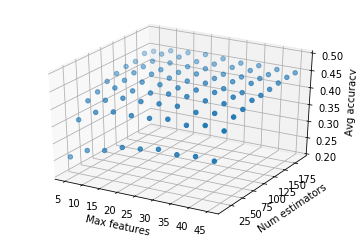

In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
fig.clf()
ax = fig.gca(projection='3d')
x = rf_params[:,0]
y = rf_params[:,1]
z = rf_params[:,2]
ax.scatter(x, y, z)
ax.set_zlim(0.2, 0.5)
ax.set_xlabel('Max features')
ax.set_ylabel('Num estimators')
ax.set_zlabel('Avg accuracy')
plt.show()

In [103]:
from sklearn.decomposition import PCA
PCA.

In [104]:
pca = PCA()

In [105]:
pca.fit(df_train_att)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [108]:
var = pca.explained_variance_ratio_

In [109]:
var

array([  4.08e-02,   3.52e-02,   3.14e-02,   2.79e-02,   2.43e-02,
         2.37e-02,   2.26e-02,   1.96e-02,   1.84e-02,   1.80e-02,
         1.77e-02,   1.68e-02,   1.60e-02,   1.33e-02,   1.31e-02,
         1.04e-02,   9.44e-03,   8.81e-03,   8.10e-03,   7.23e-03,
         6.91e-03,   6.52e-03,   6.29e-03,   6.17e-03,   5.91e-03,
         5.83e-03,   5.70e-03,   5.67e-03,   5.56e-03,   5.34e-03,
         5.21e-03,   5.18e-03,   5.09e-03,   5.00e-03,   4.94e-03,
         4.88e-03,   4.84e-03,   4.77e-03,   4.70e-03,   4.67e-03,
         4.64e-03,   4.59e-03,   4.58e-03,   4.50e-03,   4.46e-03,
         4.42e-03,   4.36e-03,   4.33e-03,   4.28e-03,   4.25e-03,
         4.20e-03,   4.17e-03,   4.13e-03,   4.07e-03,   4.03e-03,
         4.02e-03,   3.98e-03,   3.93e-03,   3.91e-03,   3.88e-03,
         3.86e-03,   3.84e-03,   3.81e-03,   3.75e-03,   3.73e-03,
         3.71e-03,   3.69e-03,   3.65e-03,   3.63e-03,   3.60e-03,
         3.57e-03,   3.56e-03,   3.54e-03,   3.53e-03,   3.49e

In [110]:
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

In [113]:
var1

array([  4.08,   7.6 ,  10.74,  13.53,  15.96,  18.33,  20.59,  22.55,
        24.39,  26.19,  27.96,  29.64,  31.24,  32.57,  33.88,  34.92,
        35.86,  36.74,  37.55,  38.27,  38.96,  39.61,  40.24,  40.86,
        41.45,  42.03,  42.6 ,  43.17,  43.73,  44.26,  44.78,  45.3 ,
        45.81,  46.31,  46.8 ,  47.29,  47.77,  48.25,  48.72,  49.19,
        49.65,  50.11,  50.57,  51.02,  51.47,  51.91,  52.35,  52.78,
        53.21,  53.64,  54.06,  54.48,  54.89,  55.3 ,  55.7 ,  56.1 ,
        56.5 ,  56.89,  57.28,  57.67,  58.06,  58.44,  58.82,  59.19,
        59.56,  59.93,  60.3 ,  60.66,  61.02,  61.38,  61.74,  62.1 ,
        62.45,  62.8 ,  63.15,  63.5 ,  63.84,  64.18,  64.52,  64.86,
        65.2 ,  65.53,  65.86,  66.19,  66.52,  66.85,  67.17,  67.49,
        67.81,  68.13,  68.45,  68.77,  69.08,  69.39,  69.7 ,  70.01,
        70.32,  70.62,  70.92,  71.22,  71.52,  71.82,  72.11,  72.4 ,
        72.69,  72.98,  73.26,  73.54,  73.82,  74.1 ,  74.38,  74.65,
      

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([], dtype=int64),)

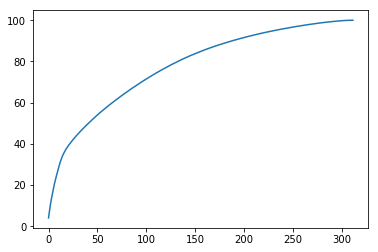

In [122]:
plt.plot(var1)


In [125]:
np.where(var1 == 95.02)

(array([], dtype=int64),)

In [126]:
pca = PCA(n_components=200)

In [131]:
X_train_pca = pca.fit_transform(df_train_att)

In [130]:
clf = RandomForestClassifier(max_features=40, random_state=0, n_estimators=130)

In [133]:
clf.fit(X_train_pca, df_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [136]:
X_test_pca = pca.transform(df_test_att)

In [138]:
predictions = clf.predict(X_test_pca)

In [140]:
from sklearn import metrics
metrics.accuracy_score(df_test_label, predictions)

0.36800422386483633